# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Formulation of the optimal control problem: Mobile robot

### Model description
<img src="https://raw.github.com/wiki/mayataka/CGMRES/images/fig_mobilerobot.png" width=40%>

The above figure shows the model of a mobile robot. The kinematics of the robot is given by
$$ \dot{X} = V \cos{\theta}, $$
$$ \dot{Y} = V \sin{\theta}. $$
Physical limitations of the robot are given by
$$ V_{\rm min} \leq V \leq V_{\rm max}, $$
$$ w_{\rm min} \leq \dot{\theta} \leq w_{\rm max}. $$

### Control Objective
We consider tracjectory tracking problem. We set the reference trajectory as 
$$ x_{\rm ref} (t) = \begin{bmatrix} t v_{\rm ref} \\ 0 \end{bmatrix} .$$
We also assume that there are two circular obstacles to be avoided whose center and radius are $(X_1, Y_1)$, $R_1$ and $(X_2, Y_2)$, $R_2$, respectively.

### Formulation of the optimal control problem
We define the state vector as
$$ x = \begin{bmatrix} X \\ Y \\ \theta \end{bmatrix} .$$
We assume that $V=u_1$ and $\theta = u_2$. The state equation is then given as 
$$ \dot{x} = f(t, x, u) = \begin{bmatrix} u_1 \cos{\theta} \\ u_1 \sin{\theta} \\ u_2 \end{bmatrix} $$

Next, we set the cost function 
$$ J = \varphi(t, x) + \int_{t}^{t+T} L(t, x, u) .$$
To achieve the aforementioned goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} q_1 (x_1 - t v_{\rm ref})^2 + \frac{1}{2} q_2 x_2 ^2 + \frac{1}{2} q_3 x_3 ^2 $$  
and the stage cost as 
$$ L(t, x, u) = \frac{1}{2} q_1 (x_1 - t v_{\rm ref})^2 + \frac{1}{2} q_2 x_2 ^2 + \frac{1}{2} q_3 x_3 ^2 + \frac{1}{2} r_1 (u_1 \cos{x_3} - v_{\rm ref})^2 + \frac{1}{2} r_2 u_2 ^2 $$  
where $q_1, q_2, q_3$, $r_1, r_2$ are positive real constant.
From the physical limitations and the obstacles, there are 6 inequality constraints 
$$
h(x, u) = \begin{bmatrix} R_1 ^2 - (x_1 - X_1)^2 - (x_2 - Y_1)^2 \\
                          R_2 ^2 - (x_1 - X_2)^2 - (x_2 - Y_2)^2 \\
                          v_{\rm min} - u_1 \\
                          u_1 - v_{\rm max} \\ 
                          w_{\rm min} - u_2 \\ 
                          u_2 - w_{\rm max} 
                          \end{bmatrix} \leq 0
$$
In this example, these inequality constraints are considered by the semi-smooth Fischer-Burmeister method.
In the optimization problem, the complementary conditions are imposed for inequality constraints, e.g., for $g(x, u) \in \mathbb{R}$,
$$
    g(x, u) \leq 0 ,
$$
$$
    \nu \geq 0 ,
$$
$$
    \nu g(x, u) = 0 .
$$
The semi-smooth Fischer-Burmeister method transforms these conditions into
$$
    \Phi(\nu, - g(x, u)) = 0, \;\; \Phi(a, b) = \sqrt{a^2 + b^2 + \epsilon ^2} - (a + b) .
$$
where $\epsilon > 0$ is a regularization term. 
After all, in the optimal control problem, we find the solution satisfying the following conditions
$$
    \left( \frac{\partial H}{\partial u} \right)^{\rm T} = \left( \frac{\partial L}{\partial u} \right)^{\rm T} + \left( \frac{\partial f}{\partial u} \right)^{\rm T} \lambda + \left( \frac{\partial h}{\partial u} \right)^{\rm T} \nu,
$$
$$
    \Phi(\nu_i, - h_i(x, u)) = 0 ,
$$
where $\lambda$ and $\nu$ are the Lagrange multipliers and the latter condition is imposed on elementwise.

### References 
For more details about the semi-smooth Fischer-Burmeister method in the optimal control problem, especially with the C/GMRES method, see the following references.
- [M. Huang, et. al, Nonlinear Model Predictive Control of a Diesel Engine Air Path: A Comparison of Constraint Handling and Computational Strategies, IFAC-PapersOnLine, Vol. 48, No. 23, pp. 372-379 (2015)](https://doi.org/10.1016/j.ifacol.2015.11.308)
- [M. Huang, Low Complexity Model Predictive Control of a Diesel Engine Airpath, Ph. D. diss., University of Michigan (2016)](https://deepblue.lib.umich.edu/handle/2027.42/120832)
- [S. Alamdari, S. Amin, Stochastic Model Predictive Control for Eco-Driving Assistance Systems in Electric Vehicles, Ph. D. diss., University of Luxembourg (2018)](http://orbilu.uni.lu/handle/10993/36164)
- [D. Liao-McPherson, M. Huang and I. Kolmanovsky, A Regularized and Smoothed Fischer–Burmeister Method for Quadratic Programming With Applications to Model Predictive Control, IEEE Transactions on Automatic Control, Vol. 64, No. 7, pp. 2937-2944 (2019)](https://doi.org/10.1109/TAC.2018.2872201)

### Numerical solver of NMPC
In the following example, we compute the solution of NMPC using the multiple-shooting-based C/GMRES method.

---

# Generate C++ codes of NMPC model  

## Import modules

In [1]:
from autogenu import autogenu

## Set dimensions and define `AutoGenU`
- `nx`: Dimension of the state vector $x$   
- `nu`: Dimension of the control input vector $u$  
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.

In [2]:
nx = 3
nu = 2
ocp_name = 'mobilerobot'
ag = autogenu.AutoGenU(ocp_name, nx, nu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [3]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [4]:
# Define variables used in the state function
vx_ref = ag.define_scalar_var('vx_ref')
v_min, v_max = ag.define_scalar_vars('v_min', 'v_max')
w_min, w_max = ag.define_scalar_vars('w_min', 'w_max')
X_1, Y_1, R_1 = ag.define_scalar_vars('X_1', 'Y_1', 'R_1')
X_2, Y_2, R_2 = ag.define_scalar_vars('X_2', 'Y_2', 'R_2')
xx_ref = vx_ref * t

# Variables used in the cost function
q = ag.define_array_var('q', nx)
r = ag.define_array_var('r', nu)
x_ref = ag.define_array_var('x_ref', nx)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [5]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [6]:
# Define the state equation
f = [u[0] * cos(x[2]),
     u[0] * sin(x[2]),
     u[1]]
    
# Define the equality constraints C(x, u) = 0
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = [R_1**2 - (x[0]-X_1)**2 - (x[1]-Y_1)**2,
     R_2**2 - (x[0]-X_2)**2 - (x[1]-Y_2)**2,
     v_min - u[0],
     u[0] - v_max,
     w_min - u[1],
     u[1] - w_max]

# Define the stage cost
L = (q[0]*(x[0]-xx_ref)**2 + q[1]*x[1]**2 + q[2]*x[2]**2) / 2 + (r[0]*(u[0]*cos(x[2])-vx_ref)**2 + r[1]*u[1]**2) / 2

# Define the terminal cost
phi = (q[0]*(x[0]-xx_ref)**2 + q[1]*x[1]**2 + q[2]*x[2]**2)/2 

In [7]:
# Set functions
ag.set_functions(f, C, h, L, phi)

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

- If you define the inequality constraints using Fischer-Brumeister method `h`, then you have to define related regularization term additionaly. The dimension of the regularization term must be same as the dimension of `h`. If the dimension is `nh`, you need to set the regularization as `ag.set_FB_epsilon([eps_1, ..., eps_nh])`

In [8]:
ag.set_scalar_vars(['vx_ref', 0.4], ['X_1', 1], ['Y_1', 0.25], ['R_1', 0.5],
                   ['X_2', 2], ['Y_2', -0.25], ['R_2', 0.5],
                   ['v_min', -0.5], ['v_max', 0.5],
                   ['w_min', -0.75], ['w_max', 0.75])
ag.set_array_var('q', [10, 1, 0.01])
ag.set_array_var('r', [0.1, 0.1])
ag.set_array_var('x_ref', [0, 0, 0])

ag.set_FB_epsilon([0.01, 0.01, 0.0001, 0.0001, 0.0001, 0.0001])

## Generate C++ codes of optimal control problem
Generate `ocp.hpp` that defines the optimal control problem (OCP).  
- `use_simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `use_case`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`. 

In [9]:
use_simplification = False
use_cse = True

ag.generate_source_files(use_simplification, use_cse)

---  
# Generate C++ codes for numerical simulation  

## Set NLP type  
Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)
- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.

In [10]:
nlp_type = autogenu.NLPType.MultipleShooting
ag.set_nlp_type(nlp_type)

## Set parameters for the C/GMRES method

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$. 
- `N`: The division number of the horzion for the numerical computation.  
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [11]:
Tf = 1.5
alpha = 0.0
N = 50
finite_difference_epsilon = 1.0e-08
zeta = 1000  
kmax = 15

ag.set_solver_settings(Tf, alpha, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `newton_residual_torelance`: The residual torelance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_newton_iteration`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  
- `initial_Lagrange_multiplier`: An optional parameter for `MSCGMRESWithInputSaturation`. This is a part of the initial guess of the solution, the initial guess of the Lagrange multiplier with respect the constraints on the saturation function of the control input. NOTE that this parameter has to be defined as list. If you do not specify this parameter, the all of initial Lagrange multiplier are set by 1e-03.

In [12]:
solution_initial_guess = [0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
newton_residual_torelance = 1.0e-06
max_newton_iteration = 50

ag.set_initialization_parameters(solution_initial_guess, newton_residual_torelance, max_newton_iteration)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_time`: Simulation time of the numerical simulation.  
- `sampling_time`: The sampling time of the numerical simulation.

In [13]:
initial_time = 0  
initial_state = [0, 0, 0]  
simulation_time = 10
sampling_time = 0.001  

ag.set_simulation_parameters(initial_time, initial_state, simulation_time, sampling_time)

## Generate main.cpp and CMakeLists.txt

In [14]:
ag.generate_main()
ag.generate_cmake()

## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [15]:
generator = 'Auto'  
remove_build_dir = False
ag.build(generator, remove_build_dir)
ag.run_simulation()

build_options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=ON -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/autogenu-jupyter/generated/mobilerobot/build


Scanning dependencies of target mobilerobot
[ 50%] Building CXX object CMakeFiles/mobilerobot.dir/main.cpp.o
[100%] Linking CXX executable mobilerobot
[100%] Built target mobilerobot


Start simulation
End simulation
Total CPU time for control update: 1417.97 [ms]
sampling time: 1 [ms]
CPU time for per control update: 0.141797 [ms]


## Plot the simulation results

In [16]:
%matplotlib inline
import autogenu.simulation_plottor as simplot

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at generated/mobilerobot/simulation_result/mobilerobot.pdf



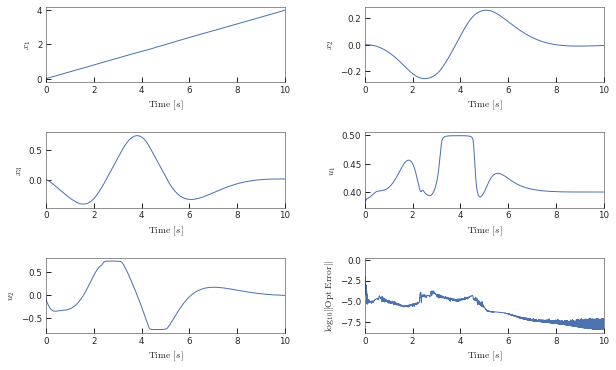

In [17]:
plot = simplot.SimulationPlottor(ocp_name)
plot.set_scales(2,5,2)
# plot.show_plots()
plot.save_plots()

## Draw animations of the simulation results

In [18]:
import autogenu.animation_generator as animgen

The animation of the simlation results is generated at generated/mobilerobot/simulation_result/mobilerobot.mp4



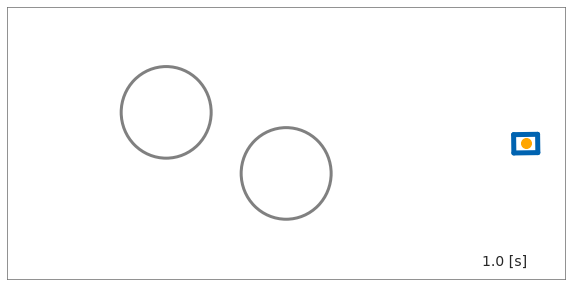

In [19]:
vx_ref = 0.4
X1, Y1, R1 = 1, 0.25, 0.5
X2, Y2, R2 = 2, -0.25, 0.5

anim = animgen.MobileRobot(ocp_name, vx_ref, X1, Y1, R1, X2, Y2, R2)
anim.set_skip_frames(10)
anim.generate_animation()

## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- The python interfaces will be installed at `~/.local/lib/python3.x`. If you use MacOSX or Windows, add it to the Python PATH as 
```
export PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages
```
where `python3.x` is your python version

In [25]:
generator = 'Auto'  
ag.generate_python_bindings()
ag.build_python_interface(generator)

build_options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=ON -DBUILD_MAIN=OFF -DBUILD_PYTHON_INTERFACE=ON
-- pybind11 v2.11.0 dev1
-- pybind11 v2.11.0 dev1
-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/autogenu-jupyter/generated/mobilerobot/build


Scanning dependencies of target solver_settings
Scanning dependencies of target horizon
Scanning dependencies of target multiple_shooting_cgmres_solver
[  8%] Building CXX object python/common/CMakeFiles/horizon.dir/horizon.cpp.o
[ 16%] Building CXX object python/common/CMakeFiles/solver_settings.dir/solver_settings.cpp.o
Scanning dependencies of target zero_horizon_ocp_solver
Scanning dependencies of target single_shooting_cgmres_solver
[ 25%] Building CXX object python/mobilerobot/CMakeFiles/multiple_shooting_cgmres_solver.dir/multiple_shooting_cgmres_solver.cpp.o
Scanning dependencies of target ocp
[ 41%] Building CXX object python/mobilerobot/CMakeFiles/zero_horizon_ocp_solver.dir/zero_horizon_o

## Install Python interface

Sometimes CMake does not recognize the built python interfaces. 
Please re-run the following cells until CMake does so.

In [28]:
ag.install_python_interface()

-- Install configuration: "Release"
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/__init__.py
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/horizon.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/solver_settings.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/mobilerobot/__init__.py
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/mobilerobot/multiple_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/mobilerobot/ocp.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/mobilerobot/single_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/mobilerobot/zero_horizon_ocp_solver.cpython-38-x86_64-linux-gnu.so

The following code shows just an example of Python interface.

In [1]:
import cgmres.mobilerobot
import cgmres.common
import numpy as np

horizon = cgmres.common.Horizon(Tf=1.0, alpha=1.0)
ocp = cgmres.mobilerobot.OCP()
settings = cgmres.common.SolverSettings()
settings.dt = 0.001

t0 = 0.0
x0 = np.zeros(ocp.nx())

# Initialize solution using zero horizon OCP solution
initializer = cgmres.mobilerobot.ZeroHorizonOCPSolver(ocp, settings)
# uc0 = np.array([0.01, 10.0, 0.01])
# initializer.set_uc(uc0)
# initializer.solve(t0, x0)
# print(initializer)

# Create MPC solver and set the initial solution 
mpc = cgmres.mobilerobot.MultipleShootingCGMRESSolver(ocp, horizon, settings)
# mpc.set_uc(initializer.ucopt())
# mpc.set_lmd(initializer.lmdopt())
# mpc.set_x(x0)
print(mpc)

# update MPC solution based on the input time and state
mpc.update(t0, x0)

# get the optimal control input and state sequence  
uopt = mpc.uopt()
xopt = mpc.xopt()

Zero horizon OCP solver: 
  kmax: 8
OCP_mobilerobot:
  nx:  3
  nu:  2
  nc:  6
  nuc: 8

  vx_ref: 0.4
  v_min: -0.5
  v_max: 0.5
  w_min: -0.75
  w_max: 0.75
  X_1: 1
  Y_1: 0.25
  R_1: 0.5
  X_2: 2
  Y_2: -0.25
  R_2: 0.5

  q:   10    1 0.01
  r: 0.1 0.1
  x_ref: 0 0 0
  fb_eps:   0.01   0.01 0.0001 0.0001 0.0001 0.0001

Soler settings: 
  max iter:                  100
  opterr tol:                0.0001
  finite difference epsilon: 1e-08
  dt (sampling period):      0.001
  zeta:                      1000
  verbose level:             0
Multiple shooting CGMRES solver: 
  N:    50
  kmax: 15
OCP_mobilerobot:
  nx:  3
  nu:  2
  nc:  6
  nuc: 8

  vx_ref: 0.4
  v_min: -0.5
  v_max: 0.5
  w_min: -0.75
  w_max: 0.75
  X_1: 1
  Y_1: 0.25
  R_1: 0.5
  X_2: 2
  Y_2: -0.25
  R_2: 0.5

  q:   10    1 0.01
  r: 0.1 0.1
  x_ref: 0 0 0
  fb_eps:   0.01   0.01 0.0001 0.0001 0.0001 0.0001

Horizon: time-varying length
  Tf:    1
  alpha: 1
  t0:    0
Soler settings: 
  max iter:               